# Projet de reconnaissance faciale

# Reconnaissance faciale avec TensorFlow

## Preparation des données

In [1]:
!pip install streamlit

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from streamlit.web.cli import activate
from tensorflow.python.ops.metrics_impl import accuracy

# Dataset parameters
dataset_path = "dataset"
batch_size = 32
img_height = 224
img_width = 224

# Get all subdirectories in the dataset folder
class_names = tf.io.gfile.listdir(str(dataset_path))

# Prepare training and validation datasets
train_images = []
train_labels = []
val_images = []
val_labels = []

for label, class_name in enumerate(class_names):
    # Get image paths for this class
    image_paths = glob.glob(f"{dataset_path}/{class_name}/*.jpg")

    for i, image_path in enumerate(image_paths):
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Split into train and validation
        if i < 3:
            train_images.append(img_array)
            train_labels.append(label)
        else:
            val_images.append(img_array)
            val_labels.append(label)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Convert labels to one-hot encoding
num_classes = len(class_names)
train_labels_onehot = np.eye(num_classes)[train_labels]
val_labels_onehot = np.eye(num_classes)[val_labels]

# Print class names
print("Classes:", class_names)

Classes: ['Angelina Jolie', 'Ben Afflek', 'Brad Pitt', 'Denzel Washington', 'Elton John', 'Hugh Jackman', 'Jennifer Lawrence', 'Jerry Seinfeld', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Madonna', 'Mathis Wauters', 'Megan Fox', 'Mindy Kaling', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


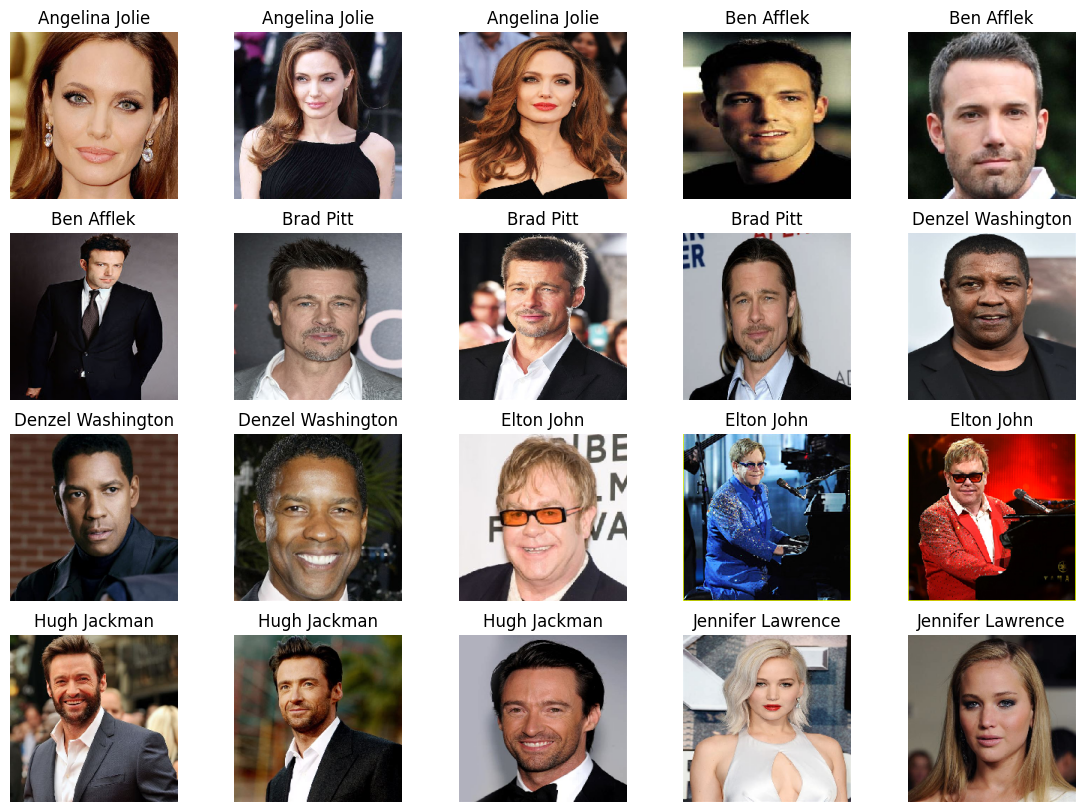

In [3]:
# Plot first 20 training images
plt.figure(figsize=(14, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis("off")
plt.show()

## Définir le modèle

In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Charger MobileNetV2 sans la dernière couche
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Geler les couches du modèle pré-entraîné
base_model.trainable = False

# Ajouter des couches personnalisées
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes))

# Compiler le modèle
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 23)                  │          29,463 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 29,463 (115.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Data augmentation et entraînement du modèle

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Préparer les générateurs de données
train_generator = train_datagen.flow(train_images, train_labels_onehot, batch_size=batch_size)
val_generator = train_datagen.flow(val_images, val_labels_onehot, batch_size=batch_size)


# Entraîner le modèle
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50)

C:\Users\samsa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.0814 - loss: 0.7754

C:\Users\samsa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0792 - loss: 0.7629 - val_accuracy: 0.0217 - val_loss: 0.3664
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0493 - loss: 0.3204 - val_accuracy: 0.0435 - val_loss: 0.2219
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0285 - loss: 0.2091 - val_accuracy: 0.0217 - val_loss: 0.1928
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0560 - loss: 0.1898 - val_accuracy: 0.0435 - val_loss: 0.1990
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1558 - loss: 0.1929 - val_accuracy: 0.0217 - val_loss: 0.1995
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 805ms/step - accuracy: 0.1453 - loss: 0.1874 - val_accuracy: 0.0652 - val_loss: 0.2093
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0932 - loss: 0.2016 - val_accuracy: 0.0652 - val_loss: 0.2063
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 874ms/step - accuracy: 0.1956 - loss: 0.1889 - val_accuracy: 0.0870 - val_loss: 0.2042
Epoch 9/50
3/3 ━━━━━━

## Visualisation des résultats

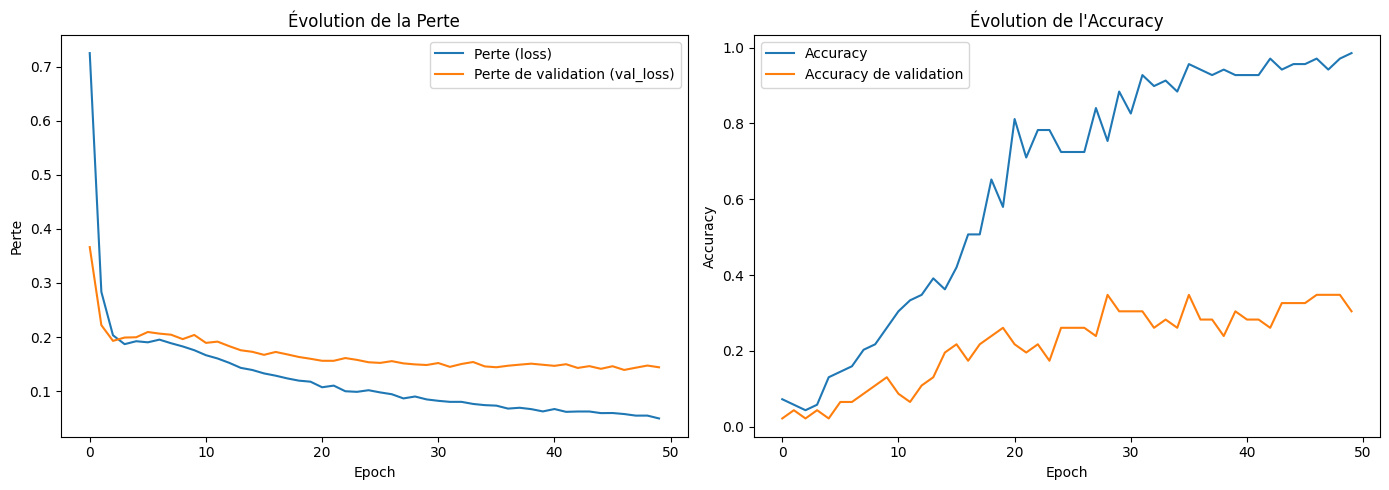

Final training accuracy: 0.9855


In [6]:
# Visualisation des résultats
import matplotlib.pyplot as plt

# Afficher la perte et l'accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (loss)')
plt.plot(history.history['val_loss'], label='Perte de validation (val_loss)')
plt.title('Évolution de la Perte')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Afficher l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy de validation')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print the final accuracy
final_accuracy = history.history['accuracy'][-1]
print(f"Final training accuracy: {final_accuracy:.4f}")

## Sauvegarde du modèle

In [7]:
model.save("face_recognition_model.keras")

## Reconnaissance faciale en temps réel

In [8]:
import cv2
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
import os
import tkinter as tk
from tkinter import Tk, Label
from tkinter import simpledialog
from tkinter import messagebox
from scipy.special import expit
import csv
from datetime import datetime
# Charger le modèle sauvegardé
model = tf.keras.models.load_model("face_recognition_model.keras")
class_names = tf.io.gfile.listdir(str('dataset'))

# Seuil de confiance pour détecter les visages inconnus
confidence_threshold = 0.6  # Ajustez ce seuil selon vos besoins

# Initialiser le classificateur de visage d'OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Dimensions des images attendues
img_height = 224
img_width = 224

# Fonction pour effectuer une prédiction
def predict_face(face, model, class_names, threshold=0.6):
    """
    Prédit la classe d'un visage et vérifie s'il est inconnu.
    Args:
        face: Image du visage.
        model: Modèle de reconnaissance faciale.
        class_names: Liste des noms de classes.
        threshold: Seuil de confiance pour les visages inconnus.

    Returns:
        predicted_class: Nom de la classe prédite ou 'Inconnu'.
        confidence: Confiance de la prédiction.
    """
    face = cv2.resize(face, (img_width, img_height))  # Redimensionner
    face_array = img_to_array(face) / 255.0  # Normaliser
    face_array = np.expand_dims(face_array, axis=0)  # Ajouter une dimension batch

    # Obtenir les prédictions (logits)
    probabilities = model.predict(face_array)[0]  # Sortie du modèle
    softmax_p = np.exp(probabilities) / np.sum(np.exp(probabilities), axis=-1)  # Probabilités softmax

    # Obtenir la classe avec la probabilité maximale
    max_index = np.argmax(softmax_p)
    confidence = expit(probabilities[max_index])

    # Vérifier si le visage est inconnu
    if confidence < threshold:
        return "Inconnu", confidence
    else:
        predicted_class = class_names[max_index]
        return predicted_class, confidence

def show_message(message, duration=5):
    """
    Affiche un message dans une fenêtre pendant une durée spécifiée.
    """
    root = Tk()
    root.title("Prochaine étape")
    root.geometry("300x100")
    label = Label(root, text=message, font=("Helvetica", 16), wraplength=280)
    label.pack(expand=True)
    root.after(duration * 1000, root.destroy)  # Ferme la fenêtre après `duration` secondes
    root.mainloop()

def capture_face(prenom, nom):
    # Créer le dossier pour enregistrer les images si il n'existe pas
    folder_name = f"dataset/{prenom.capitalize()} {nom.capitalize()}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Ouvrir la caméra
    cap = cv2.VideoCapture(0)
    captured_images = 0
    directions = ["Regardez en face", "Regardez en haut", "Regardez vers la droite", "Regardez en bas", "Regardez vers la gauche"]
    images_per_direction = 1  # Nombre d'images par direction
    total_images = len(directions) * images_per_direction

    direction_index = 0

    while captured_images < total_images:
        # Afficher le texte de l'étape actuelle
        current_direction = directions[direction_index]
        print(f"Etape : {current_direction}")

        # Pause de 3 secondes avec affichage de l'étape actuelle
        for i in range(3, 0, -1):
            ret, frame = cap.read()
            if not ret:
                break
            # Ajouter le texte pour guider l'utilisateur
            cv2.putText(frame, f"{current_direction} dans {i} secondes",
                        (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.imshow('Capturer le visage', frame)
            cv2.waitKey(1000)

        while captured_images < (direction_index + 1) * images_per_direction:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir en niveaux de gris pour la détection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Détection des visages
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            for (x, y, w, h) in faces:
                # Élargir la zone pour prendre toute la tête
                x_head = max(0, x - int(0.2 * w))  # 20% de plus sur les côtés
                y_head = max(0, y - int(0.3 * h))  # 30% de plus en haut pour inclure plus de tête
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))  # Largeur augmentée
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))  # Hauteur augmentée

                # Extraire toute la tête
                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]

                # Enregistrer l'image
                head_filename = f"{folder_name}/head_{captured_images}.jpg"
                cv2.imwrite(head_filename, head)
                captured_images += 1

                # Ajouter un rectangle et des informations à l'écran
                cv2.putText(frame, f"Image {captured_images}/{total_images}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), (0, 255, 0), 2)

            # Afficher l'étape actuelle pendant la capture
            cv2.putText(frame, f"Etape actuelle : {current_direction}",
                        (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

            # Afficher le flux vidéo avec les visages détectés
            cv2.imshow('Capturer le visage', frame)

            # Quitter avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return

        # Passer à la prochaine direction
        direction_index = (direction_index + 1) % len(directions)

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()
    show_message(f"Enregistrement terminé. Les visages ont été enregistrés dans le dossier : {folder_name}")

# Fonction pour analyser les visages
def analyze_face():
    cap = cv2.VideoCapture(0)
    log_file = "face_detection_logs.csv"

    # Créer ou vérifier le fichier de logs
    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Date', 'Heure', 'Personne'])

    # Variable pour suivre la dernière personne détectée
    last_person = None
    # Timer pour la durée minimale entre deux logs de la même personne (5 secondes)
    last_log_time = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convertir en niveaux de gris pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Détection des visages
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        current_time = time.time()

        for (x, y, w, h) in faces:
            # Élargir la zone pour capturer toute la tête (même logique que dans `capture_face`)
            x_head = max(0, x - int(0.2 * w))  # 20% de plus sur les côtés
            y_head = max(0, y - int(0.3 * h))  # 30% de plus en haut
            w_head = min(frame.shape[1] - x_head, int(w * 1.4))  # Largeur augmentée
            h_head = min(frame.shape[0] - y_head, int(h * 1.6))  # Hauteur augmentée

            # Extraire toute la tête
            head = frame[y_head:y_head+h_head, x_head:x_head+w_head]

            # Prédire la classe et la confiance
            predicted_class, confidence = predict_face(head, model, class_names)

            # Déterminer si on doit logger cette détection
            if confidence < confidence_threshold:
                person = "Inconnu"
            else:
                person = predicted_class

            # Logger seulement si la personne est différente ou si 5 secondes se sont écoulées
            if (person != last_person and confidence >= confidence_threshold) or \
               (current_time - last_log_time >= 5):
                now = datetime.now()
                date_str = now.strftime("%Y-%m-%d")
                time_str = now.strftime("%H:%M:%S")
                
                with open(log_file, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([date_str, time_str, person])
                
                last_person = person
                last_log_time = current_time

            # Affichage comme avant
            if confidence < confidence_threshold:
                text = "Visage Inconnu"
                color = (0, 0, 255)
            else:
                text = f"{predicted_class}"  # Supprimé l'affichage de la confiance
                color = (0, 255, 0)

            # Dessiner le rectangle et le texte
            cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), color, 2)
            cv2.putText(frame, text, (x_head, y_head - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        cv2.imshow('Reconnaissance Faciale', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Interface graphique
def create_interface():
    # Fenêtre principale
    window = tk.Tk()
    window.title("Reconnaissance Faciale")

    # Fonction pour enregistrer un visage
    def start_capture():
        prenom = simpledialog.askstring("Prénom", "Entrez votre prénom:")
        nom = simpledialog.askstring("Nom", "Entrez votre nom:")
        if prenom and nom:
            capture_face(prenom, nom)

    # Fonction pour analyser les visages
    def start_analyze():
        analyze_face()

    # Boutons pour chaque fonctionnalité
    capture_button = tk.Button(window, text="Enregistrer un visage", command=start_capture)
    capture_button.pack(pady=10)

    analyze_button = tk.Button(window, text="Analyser un visage", command=start_analyze)
    analyze_button.pack(pady=10)

    # Lancer l'interface
    window.mainloop()

# Lancer l'interface
create_interface()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━